<a href="https://colab.research.google.com/github/clairendo4/KDM-ICP3/blob/main/triplet_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import spacy

def extract_relations(doc):

    spans = list(doc.ents) + list(doc.noun_chunks)    #defining entities and relations
    for span in spans:
        span.merge()
    
    triples = []
        
    for ent in doc.ents:
        preps = [prep for prep in ent.root.head.children if prep.dep_ == "prep"]
        for prep in preps:
            for child in prep.children:
                triples.append((ent.text, "{} {}".format(ent.root.head, prep), child.text))
            
    
    return triples

TEXTS = [
    'Apple was founded in Cupertino in the year 1981',
    'mold and germs can form very easily in those two rooms',


  ]
    
nlp = spacy.load("en")

for text in TEXTS:
    print("\n" + text)
    relations = extract_relations(nlp(text))
    for r1, r2, r3 in relations:
        print('({}, {}, {})'.format(r1, r2, r3))


Apple was founded in Cupertino in the year 1981
(Apple, founded in, Cupertino)
(Apple, founded in, the year 1981)

mold and germs can form very easily in those two rooms
(mold, form in, those two rooms)


Yaounde is the capital and largest city of Cameroon.UMKC is located in Missouri.Keep your kitchen and bathrooms clean.Joe Biden is the president of the America
Yaounde -> nsubj
is -> ROOT
the -> det
capital -> attr
and -> cc
largest -> amod
city -> conj
of -> prep
Cameroon -> pobj
. -> punct
Yaounde , be capital large , Cameroon
UMKC -> nsubjpass
is -> auxpass
located -> ROOT
in -> prep
Missouri -> pobj
. -> punct
UMKC , locate , Missouri
Keep -> ROOT
your -> poss
kitchen -> dobj
and -> cc
bathrooms -> conj
clean -> oprd
. -> punct
 , keep , kitchen
Joe -> compound
Biden -> nsubj
is -> ROOT
the -> det
president -> attr
of -> prep
the -> det
America -> pobj
Biden , be president , America


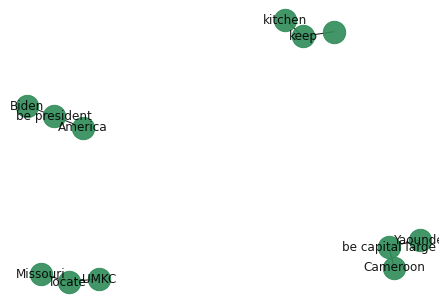

In [70]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]
#this code will make use of spacy to figure out what kind of word is every word in the sentence as it splits every sentence into tokens and attaches a tag
def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk
#you can choose as many tags as you want but let us focus on the below tags i chose; this set of tags are for relations
def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)
# i chose the below tags for entities as in my subjects and objects
def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)
# the code below helps us display a knowledge graph
def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

if __name__ == "__main__":

    text = "Yaounde is the capital and largest city of Cameroon." \
           "UMKC is located in Missouri." \
           "Keep your kitchen and bathrooms clean."\
           "Joe Biden is the president of the America"

    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)

Same code with just one sentence so we can see graph clearly and also no defination of each word



Some products contain chemicals
Some -> det
products -> nsubj
contain -> ROOT
chemicals -> dobj
products , contain , chemicals


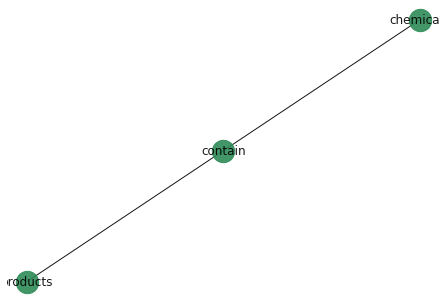

In [71]:
if __name__ == "__main__":
    
    text = 'Some products contain chemicals'

    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))
        printGraph(triples)       #showing the knowledge graph of the IE